In [2]:
import trimesh
import os
import pandas
import pickle
import subprocess
import kaolin as kal
import kaolin.conversions.meshconversions as mesh_cvt
from kaolin.transforms import pointcloudfunc as pcfunc
from kaolin.transforms import transforms as tfs
import torch
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import sys
sys.path.insert(0, '/home/mil/kawana/workspace/occupancy_networks')
from im2mesh.utils import binvox_rw
import math
import numpy as np

In [3]:
synset_to_label = {"02691156": "airplane",
"02828884": "bench",
"02933112": "cabinet",
"02958343": "car",
"03001627": "chair",
"03211117": "display",
"03636649": "lamp",
"03691459": "loudspeaker",
"04090263": "rifle",
"04256520": "sofa",
"04379243": "table",
"04401088": "telephone",
"04530566": "vessel"}
label_to_synset = {v: k for k, v in synset_to_label.items()}

shapenetv1_path = '/data/unagi0/kawana/workspace/ShapeNetCore.v1'
shapenetv2_path = '/data/unagi0/kawana/workspace/ShapeNetCore.v2'
shapenetocc_path = '/home/mil/kawana/workspace/occupancy_networks/data/ShapeNet'
side_length_scale = 0.0107337006427915

In [4]:
class_name = 'airplane'
base_eval_dir = '/home/mil/kawana/workspace/occupancy_networks/out/submission/eval/img/pnet_finetue_only_transition_cceff10_pn30_target_n_4096_no_overlap_reg_20200413_015954'
rendering_script_path = '/home/mil/kawana/workspace/occupancy_networks/scripts/render_3dobj.sh'
rendering_out_base_dir = '/home/mil/kawana/workspace/occupancy_networks/paper_resources/compare_mesh_methods'
rendering_out_dir = os.path.join(rendering_out_base_dir, 'resources')
rendering_gt_mesh_cache_dir = os.path.join(rendering_out_base_dir, 'cache')

id_to_mesh_dir_names = {
    'd2': 'generation_explicit_subdiv2',
    'd4': 'generation_explicit',
    'u0': 'generation_upsampling0',
    'u1': 'generation_upsampling1',
    'u2': 'generation'
}
id_to_fscore_pkl_map = {
    'd2': 'eval_fscore_from_meshes_full_explicit.pkl',
    'd4': 'eval_fscore_from_meshes_full_explicit.pkl',
    'u0': 'eval_fscore_from_meshes_full.pkl',
    'u1': 'eval_fscore_from_meshes_full.pkl',
    'u2': 'eval_fscore_from_meshes_full.pkl'
}
dmarker = 'o'
umarker = 'x'
markers_map = {
    'd2': dmarker,
    'd4': dmarker,
    'u0': umarker,
    'u1': umarker,
    'u2': umarker
}

legend_texts_map = {
    'd2': 'Ours div2',
    'd4': 'Ours div4',
    'u0': 'MC',
    'u1': 'MISE up1',
    'u2': 'MISE up2'
}

ids = list(id_to_fscore_pkl_map.keys())
time_pkl_name = 'time_generation_full.pkl'

best_mesh_dir_id = 'd4'
worst_mesh_dir_id = 'u0'

gdf = pickle.load(open(os.path.join(base_eval_dir, id_to_mesh_dir_names[best_mesh_dir_id], id_to_fscore_pkl_map[best_mesh_dir_id]), 'rb'))
gdf = gdf[gdf['class id'] == label_to_synset[class_name]]

wdf = pickle.load(open(os.path.join(base_eval_dir, id_to_mesh_dir_names[worst_mesh_dir_id], id_to_fscore_pkl_map[worst_mesh_dir_id]), 'rb'))
wdf = wdf[wdf['class id'] == label_to_synset[class_name]]


assert len(gdf) == len(wdf), (len(gdf), len(wdf))

fscore_key = 'fscore_th={} (mesh)'.format(side_length_scale)

gdf['diff'] = (gdf[fscore_key] - wdf[fscore_key])

filter = gdf[fscore_key] > 0.9
idx = gdf[filter]['diff'].argmax()
model_id = gdf[filter]['modelname'].iloc[idx]





In [5]:
def as_mesh(scene_or_mesh):
    """
    Convert a possible scene to a mesh.

    If conversion occurs, the returned mesh has only vertex and face data.
    """
    if isinstance(scene_or_mesh, trimesh.Scene):
        if len(scene_or_mesh.geometry) == 0:
            mesh = None  # empty scene
        else:
            # we lose texture information here
            mesh = trimesh.util.concatenate(
                tuple(trimesh.Trimesh(vertices=g.vertices, faces=g.faces)
                    for g in scene_or_mesh.geometry.values()))
    else:
        assert(isinstance(mesh, trimesh.Trimesh))
        mesh = scene_or_mesh
    return mesh

In [15]:
model_paths = {
    idx: os.path.join(base_eval_dir, id_to_mesh_dir_names[idx], 'meshes', label_to_synset[class_name], str(model_id)+'.off') for idx in ids 
}
shapenet_model_path = os.path.join(shapenetv1_path, label_to_synset[class_name], model_id, 'model.obj')
#shapenet_model_path = os.path.join(shapenetv2_path, label_to_synset[class_name], model_id, 'models', 'model_normalized.solid.binvox')
#shapenet_model_path = os.path.join(shapenetocc_path, label_to_synset[class_name], model_id, 'model.binvox')


gt_mesh_cache_path = os.path.join(rendering_gt_mesh_cache_dir, model_id+'.obj')
if not os.path.exists(gt_mesh_cache_path) or True:
    mesh = as_mesh(trimesh.load(shapenet_model_path))


    min = [0]*3
    max = [0]*3

    for i in range(3):
        min[i] = np.min(mesh.vertices[:, i])
        max[i] = np.max(mesh.vertices[:, i])

    bb_min, bb_max = tuple(min), tuple(max)

    # Get extents of model.
    bb_min, bb_max = np.array(bb_min), np.array(bb_max)
    total_size = (bb_max - bb_min).max()

    # Set the center (although this should usually be the origin already).
    centers = np.array([[
        (bb_min[0] + bb_max[0]) / 2,
        (bb_min[1] + bb_max[1]) / 2,
        (bb_min[2] + bb_max[2]) / 2
    ]])
    # Scales all dimensions equally.
    scale = total_size


    mesh.vertices -= centers
    mesh.vertices *=  1./scale
    mesh.vertices *= (1 + side_length_scale)
    mesh.export(gt_mesh_cache_path)
model_paths['gt'] = gt_mesh_cache_path


f_scores = {}
for idx in ids:
    df = pickle.load(open(os.path.join(base_eval_dir, id_to_mesh_dir_names[idx], id_to_fscore_pkl_map[idx]), 'rb'))
    f_score = df[df['class id'] == label_to_synset[class_name]][fscore_key].mean().item()
    f_scores[idx] = f_score

times = {}
for idx in ids:
    df = pickle.load(open(os.path.join(base_eval_dir, id_to_mesh_dir_names[idx], time_pkl_name), 'rb'))
    times[idx] = df[df['class id'] == label_to_synset[class_name]]['mesh'].mean().item()


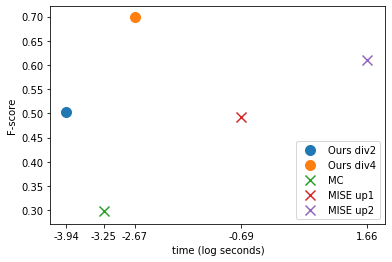

In [16]:
times_plot = [times[idx] for idx in ids]
f_scores_plot = [f_scores[idx] for idx in ids]
markers = [markers_map[idx] for idx in ids]
legend_texts = [legend_texts_map[idx] for idx in ids]

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

for t, f, m, idx in zip(times_plot, f_scores_plot, markers, ids):
    ax.scatter(math.log(t), f, marker=m, s=100, label=idx)
ax.legend(legend_texts, loc='lower right', fontsize=10)
ax.set_xlabel('time (log seconds)', fontsize=10)
ax.set_ylabel('F-score', fontsize=10)
#ax.set_xticklabels([t for t in times_plot])

ax.set_xticks([math.log(t) for t in times_plot])

ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

fig.savefig(os.path.join(rendering_out_dir, 'plot.png'), bbox_inches="tight", pad_inches=0.05)



In [17]:
if not os.path.exists(rendering_out_dir):
    os.makedirs(rendering_out_dir)

camera_param_path = os.path.join(rendering_out_base_dir, 'camera_param.txt')

for idx in model_paths:
    command = 'sh {script} {camera_param} {model} {out_dir} {idx}'.format(script=rendering_script_path, camera_param=camera_param_path, model=model_paths[idx], out_dir=rendering_out_dir, idx=idx)
    print(command)
    subprocess.run(command, shell=True)

sh /home/mil/kawana/workspace/occupancy_networks/scripts/render_3dobj.sh /home/mil/kawana/workspace/occupancy_networks/paper_resources/compare_mesh_methods/camera_param.txt /home/mil/kawana/workspace/occupancy_networks/out/submission/eval/img/pnet_finetue_only_transition_cceff10_pn30_target_n_4096_no_overlap_reg_20200413_015954/generation_explicit_subdiv2/meshes/02691156/ffccda82ecc0d0f71740529c616cd4c7.off /home/mil/kawana/workspace/occupancy_networks/paper_resources/compare_mesh_methods/resources d2
sh /home/mil/kawana/workspace/occupancy_networks/scripts/render_3dobj.sh /home/mil/kawana/workspace/occupancy_networks/paper_resources/compare_mesh_methods/camera_param.txt /home/mil/kawana/workspace/occupancy_networks/out/submission/eval/img/pnet_finetue_only_transition_cceff10_pn30_target_n_4096_no_overlap_reg_20200413_015954/generation_explicit/meshes/02691156/ffccda82ecc0d0f71740529c616cd4c7.off /home/mil/kawana/workspace/occupancy_networks/paper_resources/compare_mesh_methods/resourc